## TSNE Resolve Colors Bug Documentation

Jerome Massot [reports](https://github.com/DistrictDataLabs/yellowbrick/pull/658) that there is a bug in TSNE that means that colors that are passed in on instantiation do not affect the colors of the plot.

In this example, we'll validate that the bug exists, and that his proposed solution works

In [1]:
import os
import sys 

# Modify the path 
sys.path.append("..")

import pandas as pd
import yellowbrick as yb
import matplotlib.pyplot as plt 

### Validate Bug

In [2]:
from download import download_all 
from sklearn.datasets.base import Bunch

## The path to the test data sets
FIXTURES  = os.path.join(os.getcwd(), "data")

## Dataset loading mechanisms
datasets = {
    "hobbies": os.path.join(FIXTURES, "hobbies")
}


def load_data(name, download=True):
    """
    Loads and wrangles the passed in text corpus by name.
    If download is specified, this method will download any missing files. 
    """
    
    # Get the path from the datasets 
    path = datasets[name]
    
    # Check if the data exists, otherwise download or raise 
    if not os.path.exists(path):
        if download:
            download_all() 
        else:
            raise ValueError((
                "'{}' dataset has not been downloaded, "
                "use the download.py module to fetch datasets"
            ).format(name))
    
    # Read the directories in the directory as the categories. 
    categories = [
        cat for cat in os.listdir(path) 
        if os.path.isdir(os.path.join(path, cat))
    ]
    
    
    files  = [] # holds the file names relative to the root 
    data   = [] # holds the text read from the file 
    target = [] # holds the string of the category 
        
    # Load the data from the files in the corpus 
    for cat in categories:
        for name in os.listdir(os.path.join(path, cat)):
            files.append(os.path.join(path, cat, name))
            target.append(cat)
            
            with open(os.path.join(path, cat, name), 'r') as f:
                data.append(f.read())
        
    
    # Return the data bunch for use similar to the newsgroups example
    return Bunch(
        categories=categories,
        files=files,
        data=data,
        target=target,
    )

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = load_data('hobbies')
tfidf  = TfidfVectorizer()

docs   = tfidf.fit_transform(corpus.data)
labels = corpus.target

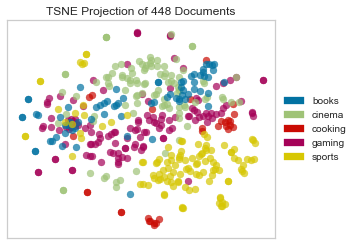

In [4]:
from yellowbrick.text import TSNEVisualizer

tsne = TSNEVisualizer(colors=["purple","blue","orchid","indigo","plum","navy"])
tsne.fit(docs, labels)
tsne.poof()

### Validate Solution

In [5]:
import numpy as np

from collections import defaultdict

from yellowbrick.draw import manual_legend
from yellowbrick.text.base import TextVisualizer
from yellowbrick.style.colors import resolve_colors
from yellowbrick.exceptions import YellowbrickValueError

from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD, PCA

##########################################################################
## Quick Methods
##########################################################################

def tsne(X, y=None, ax=None, decompose='svd', decompose_by=50, classes=None,
           colors=None, colormap=None, alpha=0.7, **kwargs):
    """
    Display a projection of a vectorized corpus in two dimensions using TSNE,
    a nonlinear dimensionality reduction method that is particularly well
    suited to embedding in two or three dimensions for visualization as a
    scatter plot. TSNE is widely used in text analysis to show clusters or
    groups of documents or utterances and their relative proximities.

    Parameters
    ----------

    X : ndarray or DataFrame of shape n x m
        A matrix of n instances with m features representing the corpus of
        vectorized documents to visualize with tsne.

    y : ndarray or Series of length n
        An optional array or series of target or class values for instances.
        If this is specified, then the points will be colored according to
        their class. Often cluster labels are passed in to color the documents
        in cluster space, so this method is used both for classification and
        clustering methods.

    ax : matplotlib axes
        The axes to plot the figure on.

    decompose : string or None
        A preliminary decomposition is often used prior to TSNE to make the
        projection faster. Specify `"svd"` for sparse data or `"pca"` for
        dense data. If decompose is None, the original data set will be used.

    decompose_by : int
        Specify the number of components for preliminary decomposition, by
        default this is 50; the more components, the slower TSNE will be.

    classes : list of strings
        The names of the classes in the target, used to create a legend.

    colors : list or tuple of colors
        Specify the colors for each individual class

    colormap : string or matplotlib cmap
        Sequential colormap for continuous target

    alpha : float, default: 0.7
        Specify a transparency where 1 is completely opaque and 0 is completely
        transparent. This property makes densely clustered points more visible.

    kwargs : dict
        Pass any additional keyword arguments to the TSNE transformer.

    Returns
    -------
    ax : matplotlib axes
        Returns the axes that the parallel coordinates were drawn on.
    """
    # Instantiate the visualizer
    visualizer = TSNEVisualizer(
        ax, decompose, decompose_by, classes, colors, colormap, alpha, **kwargs
    )

    # Fit and transform the visualizer (calls draw)
    visualizer.fit(X, y, **kwargs)
    visualizer.transform(X)

    # Return the axes object on the visualizer
    return visualizer.ax


##########################################################################
## TSNEVisualizer
##########################################################################

class TSNEVisualizer(TextVisualizer):
    """
    Display a projection of a vectorized corpus in two dimensions using TSNE,
    a nonlinear dimensionality reduction method that is particularly well
    suited to embedding in two or three dimensions for visualization as a
    scatter plot. TSNE is widely used in text analysis to show clusters or
    groups of documents or utterances and their relative proximities.

    TSNE will return a scatter plot of the vectorized corpus, such that each
    point represents a document or utterance. The distance between two points
    in the visual space is embedded using the probability distribution of
    pairwise similarities in the higher dimensionality; thus TSNE shows
    clusters of similar documents and the relationships between groups of
    documents as a scatter plot.

    TSNE can be used with either clustering or classification; by specifying
    the ``classes`` argument, points will be colored based on their similar
    traits. For example, by passing ``cluster.labels_`` as ``y`` in ``fit()``, all
    points in the same cluster will be grouped together. This extends the
    neighbor embedding with more information about similarity, and can allow
    better interpretation of both clusters and classes.

    For more, see https://lvdmaaten.github.io/tsne/

    Parameters
    ----------

    ax : matplotlib axes
        The axes to plot the figure on.

    decompose : string or None, default: ``'svd'``
        A preliminary decomposition is often used prior to TSNE to make the
        projection faster. Specify ``"svd"`` for sparse data or ``"pca"`` for
        dense data. If None, the original data set will be used.

    decompose_by : int, default: 50
        Specify the number of components for preliminary decomposition, by
        default this is 50; the more components, the slower TSNE will be.

    labels : list of strings
        The names of the classes in the target, used to create a legend.
        Labels must match names of classes in sorted order.

    colors : list or tuple of colors
        Specify the colors for each individual class

    colormap : string or matplotlib cmap
        Sequential colormap for continuous target

    random_state : int, RandomState instance or None, optional, default: None
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by np.random. The random state is applied to the preliminary
        decomposition as well as tSNE.

    alpha : float, default: 0.7
        Specify a transparency where 1 is completely opaque and 0 is completely
        transparent. This property makes densely clustered points more visible.

    kwargs : dict
        Pass any additional keyword arguments to the TSNE transformer.
    """

    # NOTE: cannot be np.nan
    NULL_CLASS = None

    def __init__(self, ax=None, decompose='svd', decompose_by=50,
                 labels=None, classes=None, colors=None, colormap=None,
                 random_state=None, alpha=0.7, **kwargs):

        # Visual Parameters
        self.alpha = alpha
        self.labels = labels
        self.colors = colors
        self.colormap = colormap
        self.random_state = random_state

        # Fetch TSNE kwargs from kwargs by popping only keys belonging to TSNE params
        tsne_kwargs = {
            key: kwargs.pop(key)
            for key in TSNE().get_params()
            if key in kwargs
        }
        self.transformer_ = self.make_transformer(decompose, decompose_by, tsne_kwargs)

        # Call super at the end so that size and title are set correctly
        super(TSNEVisualizer, self).__init__(ax=ax, **kwargs)

    def make_transformer(self, decompose='svd', decompose_by=50, tsne_kwargs={}):
        """
        Creates an internal transformer pipeline to project the data set into
        2D space using TSNE, applying an pre-decomposition technique ahead of
        embedding if necessary. This method will reset the transformer on the
        class, and can be used to explore different decompositions.

        Parameters
        ----------

        decompose : string or None, default: ``'svd'``
            A preliminary decomposition is often used prior to TSNE to make
            the projection faster. Specify ``"svd"`` for sparse data or ``"pca"``
            for dense data. If decompose is None, the original data set will
            be used.

        decompose_by : int, default: 50
            Specify the number of components for preliminary decomposition, by
            default this is 50; the more components, the slower TSNE will be.

        Returns
        -------

        transformer : Pipeline
            Pipelined transformer for TSNE projections
        """

        # TODO: detect decompose by inferring from sparse matrix or dense or
        # If number of features > 50 etc.
        decompositions = {
            'svd': TruncatedSVD,
            'pca': PCA,
        }

        if decompose and decompose.lower() not in decompositions:
            raise YellowbrickValueError(
                "'{}' is not a valid decomposition, use {}, or None".format(
                    decompose, ", ".join(decompositions.keys())
                )
            )

        # Create the pipeline steps
        steps = []

        # Add the pre-decomposition
        if decompose:
            klass = decompositions[decompose]
            steps.append((decompose, klass(
                n_components=decompose_by, random_state=self.random_state)))

        # Add the TSNE manifold
        steps.append(('tsne', TSNE(
            n_components=2, random_state=self.random_state, **tsne_kwargs)))

        # return the pipeline
        return Pipeline(steps)

    def fit(self, X, y=None, **kwargs):
        """
        The fit method is the primary drawing input for the TSNE projection
        since the visualization requires both X and an optional y value. The
        fit method expects an array of numeric vectors, so text documents must
        be vectorized before passing them to this method.

        Parameters
        ----------
        X : ndarray or DataFrame of shape n x m
            A matrix of n instances with m features representing the corpus of
            vectorized documents to visualize with tsne.

        y : ndarray or Series of length n
            An optional array or series of target or class values for
            instances. If this is specified, then the points will be colored
            according to their class. Often cluster labels are passed in to
            color the documents in cluster space, so this method is used both
            for classification and clustering methods.

        kwargs : dict
            Pass generic arguments to the drawing method

        Returns
        -------
        self : instance
            Returns the instance of the transformer/visualizer
        """

        # Store the classes we observed in y
        if y is not None:
            self.classes_ = np.unique(y)
        elif y is None and self.labels is not None:
            self.classes_ = np.array([self.labels[0]])
        else:
            self.classes_ = np.array([self.NULL_CLASS])

        # Fit our internal transformer and transform the data.
        vecs = self.transformer_.fit_transform(X)
        self.n_instances_ = vecs.shape[0]

        # Draw the vectors
        self.draw(vecs, y, **kwargs)

        # Fit always returns self.
        return self

    def draw(self, points, target=None, **kwargs):
        """
        Called from the fit method, this method draws the TSNE scatter plot,
        from a set of decomposed points in 2 dimensions. This method also
        accepts a third dimension, target, which is used to specify the colors
        of each of the points. If the target is not specified, then the points
        are plotted as a single cloud to show similar documents.
        """
        # Resolve the labels with the classes
        labels = self.labels if self.labels is not None else self.classes_
        if len(labels) != len(self.classes_):
            raise YellowbrickValueError((
                "number of supplied labels ({}) does not "
                "match the number of classes ({})"
            ).format(len(labels), len(self.classes_)))


        # Create the color mapping for the labels.
        self.color_values_ = resolve_colors(
            n_colors=len(labels), colormap=self.colormap, colors=self.colors)
        colors = dict(zip(labels, self.color_values_))

        # Transform labels into a map of class to label
        labels = dict(zip(self.classes_, labels))

        # Expand the points into vectors of x and y for scatter plotting,
        # assigning them to their label if the label has been passed in.
        # Additionally, filter classes not specified directly by the user.
        series = defaultdict(lambda: {'x':[], 'y':[]})

        if target is not None:
            for t, point in zip(target, points):
                label = labels[t]
                series[label]['x'].append(point[0])
                series[label]['y'].append(point[1])
        else:
            label = self.classes_[0]
            for x,y in points:
                series[label]['x'].append(x)
                series[label]['y'].append(y)

        # Plot the points
        for label, points in series.items():
            self.ax.scatter(
                points['x'], points['y'], c=colors[label],
                alpha=self.alpha, label=label
            )

    def finalize(self, **kwargs):
        """
        Finalize the drawing by adding a title and legend, and removing the
        axes objects that do not convey information about TNSE.
        """
        self.set_title(
            "TSNE Projection of {} Documents".format(self.n_instances_)
        )

        # Remove the ticks
        self.ax.set_yticks([])
        self.ax.set_xticks([])

        # Add the legend outside of the figure box.
        if not all(self.classes_ == np.array([self.NULL_CLASS])):
            box = self.ax.get_position()
            self.ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
            manual_legend(
                self, self.classes_, self.color_values_,
                loc='center left', bbox_to_anchor=(1, 0.5)
            )


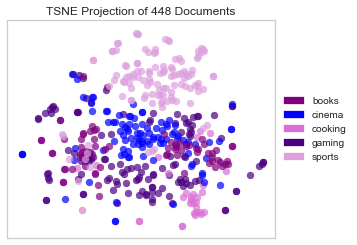

In [6]:
tsne = TSNEVisualizer(colors=["purple","blue","orchid","indigo","plum","navy"])
tsne.fit(docs, labels)
tsne.poof()